# Haputscript des Experimentes

In [56]:
!!! pip install python-dotenv openai xmltodict PyPDF2 scikit-learn pandas
!!! pip install -q spacy
!!! pip install nltk textstat
!!! python -m spacy download en_core_web_sm

["'!' is not recognized as an internal or external command,",
 'operable program or batch file.']

In [ ]:
# Setup & Imports
import csv
import glob
import os
import openai
import requests
import pandas as pd
import nltk
import re
import spacy
import textstat
import xmltodict
from openai import OpenAI
from dotenv import load_dotenv
from PyPDF2 import PdfReader
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

#start
# 1. Environment und OpenAI-Setup
load_dotenv()
client = openai.OpenAI(api_key=os.getenv("GPT_KEY"))
api_url = os.getenv("OLLAMA_URL")
token = os.getenv("OLLAMA_KEY")

def extract_txt(path_txt: str) -> str:
    with open(path_txt, "r", encoding="utf-8") as f:
        return f.read()
    
# Generate traditional M2T transformation text and Mermaid models
print("Generating traditional M2T transformation text and Mermaid models...")
os.system("ruby transform_models.script")

# Generate CSV with Mermaid model statistics
print("Generating CSV with Mermaid model statistics...")
mermaid_files = sorted(glob.glob("data/mermaid_models_fixed/*.mmd"))

with open("graph_stats.csv", "w", newline="") as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(["File", "Edges", "Tasks", "Gateways", "Density", "Cyclomatic Complexity"])

    for mermaid_file in mermaid_files:
        mermaid_text = extract_txt(mermaid_file)
        basename = os.path.splitext(os.path.basename(mermaid_file))[0]
        edge_count = mermaid_text.count("-->")
        node_matches = set(re.findall(r"(\w+):(\w+):\(([^\n\-]+)\)", mermaid_text))
        gateway_matches = set(re.findall(r"(\w+):(\w+):\{(.+?)\}", mermaid_text))

        node_count = len(node_matches) + len(gateway_matches)
        density = edge_count / (node_count * (node_count - 1)) if node_count > 1 else 0
        cyclomatic_complexity = edge_count - node_count + 2

        writer.writerow([basename, edge_count, len(node_matches), len(gateway_matches), f"{density:.4f}", cyclomatic_complexity])


Generating traditional M2T transformation text and Mermaid models...
Generating CSV with Mermaid model statistics...


In [2]:
# Stelle sicher, dass NLTK im richtigen Verzeichnis sucht
nltk.data.path = ["/Users/rowshanak/nltk_data"]

# (nur beim ersten Mal notwendig)
nltk.download("punkt", download_dir="/data/nltk_data")

[nltk_data] Downloading package punkt to /data/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [3]:
nlp = spacy.load("en_core_web_sm")
text = "Hello. This is a test. Just checking sentence tokenization."

doc = nlp(text)
sentences = [sent.text for sent in doc.sents]
print("Sentences:", sentences)

print("Number of sentences:", len(sentences))

Sentences: ['Hello.', 'This is a test.', 'Just checking sentence tokenization.']
Number of sentences: 3


In [5]:
def prompt_gpt(LLM, prompt):  # model should be "gpt-4o-mini"
    response = client.chat.completions.create(
        model=LLM,
        messages=[{"role": "user", "content": prompt}],
        max_tokens=1000,
        temperature=0.5
    )
    return response.choices[0].message.content.strip()

def prompt_ollama(LLM, prompt):
    # Available models: llama3.1:8b, deepseek-r1:14b, tinyllama:latest
    api_url = os.getenv("OLLAMA_URL")
    token = os.getenv("OLLAMA_KEY")
    headers = {
        "Authorization": f"Bearer {token}",
        "Content-Type": "application/json"
    }
    json_data = {
        "model": LLM,
        "prompt": prompt,
        "stream": False
    }

    response = requests.post(api_url, headers=headers, json=json_data)
    response.raise_for_status()  # Raises HTTPError if not 200
    return response.json()['response']

def prompt_LLM(LLM, prompt, save_to_filepath=False):
    if LLM.startswith("gpt-"):
        response = prompt_gpt(LLM, prompt)
    else:
        response = prompt_ollama(LLM, prompt)

    if save_to_filepath:
        with open(save_to_filepath, 'w') as file:
            file.write(response)
        print(f"Response saved to {save_to_filepath}")

    return response

In [6]:
# Test prompting functions
print("Testing OpenAI prompt...")
response = prompt_LLM("gpt-4o-mini", "What is the capital of Germany?")
print("OpenAI response:", response)
print("Testing Ollama prompt...")
ollama_response = prompt_LLM("llama3.1:8b", "What is the capital of Germany?")
print("Ollama response:", ollama_response)

Testing OpenAI prompt...
OpenAI response: The capital of Germany is Berlin.
Testing Ollama prompt...
Ollama response: The capital of Germany is Berlin.


In [8]:
# KPI Calcuation Functions

def compute_readability(text: str) -> dict:
    """FKGL, FRE."""
    return {
        "FKGL": textstat.flesch_kincaid_grade(text),
        "FRE":  textstat.flesch_reading_ease(text),
    }

def compute_quantitative(text: str) -> dict:
    """ #S (number of sentences), #W (Number of words), WS (words in each sentence) with spaCy."""
    doc = nlp(text)
    sentences = list(doc.sents)
    words = [token.text for token in doc if token.is_alpha]
    
    num_s = len(sentences)
    num_w = len(words)
    ws = num_w / num_s if num_s else 0.0
    
    return {
        "#S": num_s,
        "#W": num_w,
        "WS": round(ws, 2),
    }

def ts_nc(a: str, b: str) -> float:
    """non-contextual similarity (TF-IDF + Cosine)."""
    vect  = TfidfVectorizer(stop_words="english")
    tfidf = vect.fit_transform([a, b])
    return float(cosine_similarity(tfidf[0:1], tfidf[1:2])[0][0])

def ts_c(a: str, b: str, model: str = "text-embedding-ada-002") -> float:
    """contextual similarity via OpenAI embeddings."""
    resp_a = client.embeddings.create(input=a, model=model)
    resp_b = client.embeddings.create(input=b, model=model)
    emb_a  = resp_a.data[0].embedding
    emb_b  = resp_b.data[0].embedding
    return float(cosine_similarity([emb_a], [emb_b])[0][0])

def count_model_references(text: str, elements: list[str]) -> int:
    """how many of the the Modellterms exist in the Text."""
    lower = text.lower()
    return sum(lower.count(el.lower()) for el in elements)

def evaluate(text: str,
             reference: str | None,
             elements: list[str]) -> dict:
    mets = {}
    mets.update(compute_readability(text))
    mets.update(compute_quantitative(text))
    mets["#MR"] = count_model_references(text, elements)
    if reference is not None:
        mets["TS-NC"] = ts_nc(text, reference)
        mets["TS-C"]  = ts_c(text, reference)
    else:
        mets["TS-NC"] = ""
        mets["TS-C"]  = ""
    return mets

In [9]:
def csv_update(metrics: dict,
               process_model_name: str,
               llm_model_name: str,
               text_type: str,
               prompt_id: int,
               conflict: int,
               source_file: str | None = "",
               csv_path: str = "results.csv"):
    
    def get_combined_score(mets: dict) -> float:
        ts_c = mets.get("TS-C", 0) or 0
        ts_nc = mets.get("TS-NC", 0) or 0
        return round((0.7 * ts_c + 0.3 * ts_nc), 5)

    row = {
        "Process Model": process_model_name,
        "LLM Model": llm_model_name,
        "Text Type": text_type,
        "Prompt": prompt_id,
        "FKGL": metrics.get("FKGL", ""),
        "FRE": metrics.get("FRE", ""),
        "#S": metrics.get("#S", ""),
        "#W": metrics.get("#W", ""),
        "#MR": metrics.get("#MR", ""),
        "TS-NC": metrics.get("TS-NC", ""),
        "TS-C": metrics.get("TS-C", ""),
        "Conflict?": conflict,
        "Score": get_combined_score(metrics),
        "Source File": source_file if source_file else "",
    }

    # CSV schreiben
    write_header = not os.path.exists(csv_path)
    with open(csv_path, mode="a", newline="", encoding="utf-8") as file:
        writer = csv.DictWriter(file, fieldnames=row.keys())
        if write_header:
            writer.writeheader()
        writer.writerow(row)

In [10]:
def generate_M2T_texts_with_LLM(LLM, mermaid_model_name):
    print(f"Generating M2T texts for model {mermaid_model_name} using {LLM}")

    # Datei-Pfade prüfen
    gold_path = f"data/golden_descriptions/{mermaid_model_name}.txt"
    trad_path = f"data/traditional_m2t_output/{mermaid_model_name}.df-po-extended.txt"
    if not all([os.path.exists(p) for p in [gold_path, trad_path]]):
        print(f"❌ Missing data of {mermaid_model_name}, let's skip.")
        return
    
    # Schritt 2: Basisdaten laden
    description_text = extract_txt(gold_path)
    txt_text = extract_txt(trad_path)
    model_elements = ["test"]  # ggf. anpassen

    # Save metrics for non-LLM texts
    mets_trad = evaluate(txt_text, description_text if description_text else None, model_elements)
    mets_human = evaluate(description_text, None, model_elements) if description_text else {
        "FKGL": "", "FRE": "", "#S": "", "#W": "", "#MR": "", "TS-NC": "", "TS-C": ""
    }

    # CSV schreiben
    print("Updating CSV with results for traditional and human texts")
    for metrics, text_type in [(mets_trad, "Traditional"), (mets_human, "Golden Description")]:
        csv_update(
            metrics=metrics,
            process_model_name=mermaid_model_name,
            llm_model_name=LLM,
            text_type=text_type,
            prompt_id=0,
            conflict="0" if "No conflicts found." in description_text or "Number of conflicts: 0" in description_text else "1",
            source_file=gold_path if text_type == "Golden Description" else trad_path,
            csv_path="results.csv"
        )

    # Load model + reference text
    mermaid_path = os.path.join("data", "mermaid_models_fixed", f"{mermaid_model_name}.mmd")
    trad_path = os.path.join("data", "traditional_m2t_output", f"{mermaid_model_name}.df-po-extended.txt")

    with open(mermaid_path, 'r', encoding='utf-8') as f:
        mermaid_model = f.read()
    with open(trad_path, 'r', encoding='utf-8') as f:
        traditional_m2t_text = f.read()

    # Prompts definieren
    prompts = [
        f"Read the following Mermaid.js model:\n{mermaid_model}\nConvert this model to a textual process description using simple language.",
        f"Read the following Mermaid.js model:\n{mermaid_model}\nConvert this model to a textual process description without mentioning types of the model elements (i.e., task, start event, end event, gateway, etc.). Return only the textual description. Do not use newlines or bullet points, unless paragraphs are needed.",
        f"Read the following Mermaid.js model:\n{mermaid_model}\nConvert this model to a textual process description without mentioning types of the model elements (i.e., task, start event, end event, gateway, etc.). Use the following traditional M2T transformation text as a reference:\n{traditional_m2t_text}\n\nThe reference text uses a traditional M2T transformation method with minimal natural language processing and is therefore stale; this can be improved upon, use it only for reference. Return only the textual description. Do not use newlines or bullet points, unless paragraphs are needed.",
    ]

    for i, prompt in enumerate(prompts, start=1):
        prompt_id = i
        # Datei-Pfade
        base_name = f"{mermaid_model_name}_{LLM}_prompt{prompt_id}".replace(" ", "_").replace(":", "-")
        output_path = f"data/llm_m2t_output/{base_name}.txt"

        # Haupttext generieren
        m2t_text = prompt_LLM(LLM, prompt, output_path)

        # Konfliktprüfung vorbereiten
        task_extraction_prompt = f"Consider the following process description:\n{m2t_text}.\n\nReturn a numbered list of activities (each 3-5 words maximum) one by one without any additional information. Respond with the following format:\n\n\"Number of tasks: <number of tasks>\n1. <task 1>\n2. <task 2>\""
        task_out_path = f"data/llm_m2t_output/{base_name}_task_extraction.txt"
        extracted_tasks = prompt_LLM(LLM, task_extraction_prompt, task_out_path)

        conflict_check_prompt = f"Consider the following process description and list of extracted tasks:\nProcess description:\n{m2t_text}\n\nExtracted tasks:\n{extracted_tasks}\n\nIf the tasks in the process description are the same as the tasks in the extracted tasks, return 'No conflicts found.' Otherwise, return a numbered list of conflicts between the process description and the extracted tasks."
        conflict_path = f"data/llm_m2t_output/{base_name}_conflict_check.txt"
        conflict_check = prompt_LLM(LLM, conflict_check_prompt, conflict_path)
        conflicts_found = not "No conflicts found" in conflict_check and not "Number of conflicts: 0" in conflict_check

        mets_llm = evaluate(m2t_text, description_text if description_text else None, model_elements)
        csv_update(
            metrics=mets_llm,
            process_model_name=mermaid_model_name,
            llm_model_name=LLM,
            text_type="LLM-Generated Original",
            prompt_id=prompt_id,
            conflict="0" if not conflicts_found else "1",
            source_file=output_path,
            csv_path="results.csv"
        )
        
        # Wenn Konflikte, versuch zu fixen
        if conflicts_found:
            fix_prompt = f"The LLM model {LLM} was given the following prompt:\n{prompt}\n\nIt generated:\n{m2t_text}\n\nExtracted tasks:\n{extracted_tasks}\n\nConflicts:\n{conflict_check}\n\nPlease fix the process description to resolve these conflicts. Return only the fixed process description."
            fix_path = f"data/llm_m2t_output/{base_name}_conflict_fix.txt"
            fixed_text = prompt_LLM(LLM, fix_prompt, fix_path)
            print(f"🛠️ Conflict found in Prompt {prompt_id}.")

            # Check if the model still finds conflicts and record results of self-correction
            conflict_check_prompt = f"Consider the following process description and list of extracted tasks:\nProcess description:\n{fixed_text}\n\nExtracted tasks:\n{extracted_tasks}\n\nIf the tasks in the process description are the same as the tasks in the extracted tasks, return 'No conflicts found.' Otherwise, return a numbered list of conflicts between the process description and the extracted tasks."
            conflict_path = f"data/llm_m2t_output/{base_name}_conflict_check2.txt"
            conflict_check = prompt_LLM(LLM, conflict_check_prompt, conflict_path)
            conflicts_found = not "No conflicts found" in conflict_check and not "Number of conflicts: 0" in conflict_check

            if conflicts_found:
                print(f"🛠️ Conflict found in Prompt {prompt_id} self-correction.")

            mets_llm = evaluate(fixed_text, description_text if description_text else None, model_elements)
            csv_update(
                metrics=mets_llm,
                process_model_name=mermaid_model_name,
                llm_model_name=LLM,
                text_type="LLM-Generated Self-Corrected",
                prompt_id=prompt_id,
                conflict="0" if not conflicts_found else "1",
                source_file=fix_path,
                csv_path="results.csv"
            )

In [12]:
# Testing generate_M2T_texts_with_LLM function
generate_M2T_texts_with_LLM("gpt-4o-mini", "Test")
# generate_M2T_texts_with_LLM("llama3.1:8b", "Test")

Generating M2T texts for model Test using gpt-4o-mini
Updating CSV with results for traditional and human texts
Response saved to data/llm_m2t_output/Test_gpt-4o-mini_prompt1.txt
Response saved to data/llm_m2t_output/Test_gpt-4o-mini_prompt1_task_extraction.txt
Response saved to data/llm_m2t_output/Test_gpt-4o-mini_prompt1_conflict_check.txt
Response saved to data/llm_m2t_output/Test_gpt-4o-mini_prompt2.txt
Response saved to data/llm_m2t_output/Test_gpt-4o-mini_prompt2_task_extraction.txt
Response saved to data/llm_m2t_output/Test_gpt-4o-mini_prompt2_conflict_check.txt
Response saved to data/llm_m2t_output/Test_gpt-4o-mini_prompt3.txt
Response saved to data/llm_m2t_output/Test_gpt-4o-mini_prompt3_task_extraction.txt
Response saved to data/llm_m2t_output/Test_gpt-4o-mini_prompt3_conflict_check.txt


In [15]:
def main():
    mermaid_files = sorted(glob.glob("data/mermaid_models_fixed/*.mmd"))

    # for mermaid_file in mermaid_files:
    #     basename = os.path.splitext(os.path.basename(mermaid_file))[0]  # z.B. "1_2"
    #     generate_M2T_texts_with_LLM(LLM="gpt-4o-mini", mermaid_model_name=basename)

    # generate_M2T_texts_with_LLM(LLM="gpt-4o-mini", mermaid_model_name="Cement 1")
    generate_M2T_texts_with_LLM(LLM="llama3.1:8b", mermaid_model_name="Cement 1")

In [16]:
if __name__ == "__main__":
    main()

Generating M2T texts for model Cement 1 using llama3.1:8b
Updating CSV with results for traditional and human texts
Response saved to data/llm_m2t_output/Cement_1_llama3.1-8b_prompt1.txt
Response saved to data/llm_m2t_output/Cement_1_llama3.1-8b_prompt1_task_extraction.txt
Response saved to data/llm_m2t_output/Cement_1_llama3.1-8b_prompt1_conflict_check.txt
Response saved to data/llm_m2t_output/Cement_1_llama3.1-8b_prompt1_conflict_fix.txt
🛠️ Conflict found in Prompt 1.
Response saved to data/llm_m2t_output/Cement_1_llama3.1-8b_prompt1_conflict_check2.txt
Response saved to data/llm_m2t_output/Cement_1_llama3.1-8b_prompt2.txt
Response saved to data/llm_m2t_output/Cement_1_llama3.1-8b_prompt2_task_extraction.txt
Response saved to data/llm_m2t_output/Cement_1_llama3.1-8b_prompt2_conflict_check.txt
Response saved to data/llm_m2t_output/Cement_1_llama3.1-8b_prompt2_conflict_fix.txt
🛠️ Conflict found in Prompt 2.
Response saved to data/llm_m2t_output/Cement_1_llama3.1-8b_prompt2_conflict_che

/var/folders/29/tpmz3bt97k7_t01r5r28cqb40000gn/T/ipykernel_64908/545308011.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=group1, x='Text Type', y='Score', palette=custom_palette)


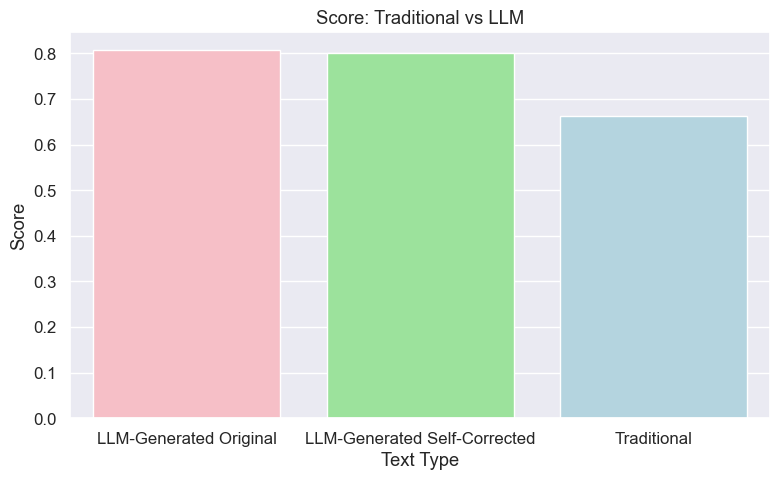

/var/folders/29/tpmz3bt97k7_t01r5r28cqb40000gn/T/ipykernel_64908/545308011.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_orig['key'] = df_orig['LLM Model'] + "_" + df_orig['Prompt'].astype(str) + "_" + df_orig['Process Model']
/var/folders/29/tpmz3bt97k7_t01r5r28cqb40000gn/T/ipykernel_64908/545308011.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_self['key'] = df_self['LLM Model'] + "_" + df_self['Prompt'].astype(str) + "_" + df_self['Process Model']


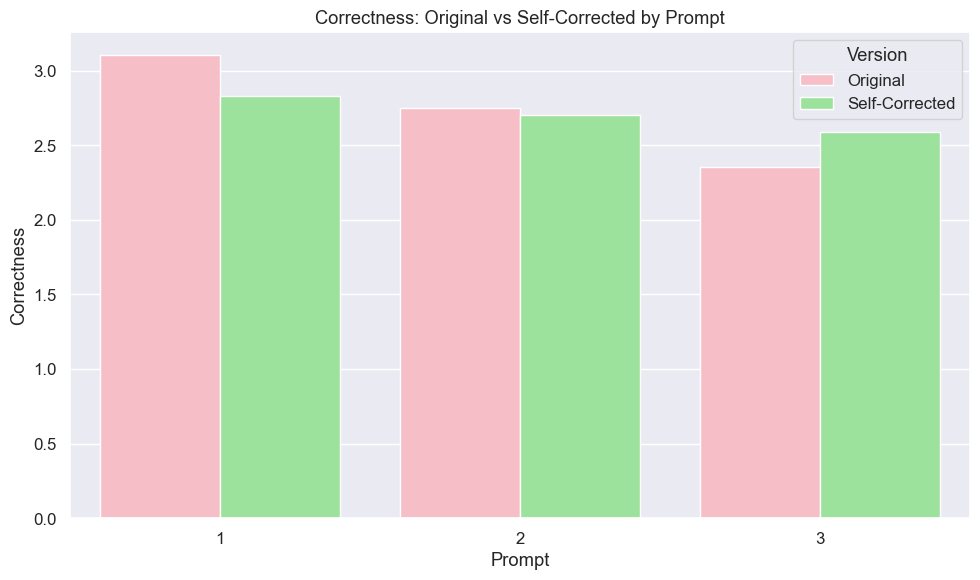

                               FKGL                                          \
                              count      mean       std       min       25%   
Text Type                                                                     
LLM-Generated Original        150.0  7.926151  2.119785  1.921923  6.756113   
LLM-Generated Self-Corrected  103.0  8.750398  2.187753  2.623556  7.405917   
Traditional                    51.0  6.460144  0.682746  4.362500  6.139442   

                                                                FRE  \
                                   50%        75%        max  count   
Text Type                                                             
LLM-Generated Original        7.826144   9.085697  15.107319  150.0   
LLM-Generated Self-Corrected  8.725968  10.099869  15.621684  103.0   
Traditional                   6.396777   6.923244   7.649017   51.0   

                                         ...                        Score  \
                     

In [ ]:
#Analysis
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
csv_path = "LLM-Generated M2T Results Analysis - CLEANED.csv"  
df = pd.read_csv(csv_path)
df = df[df['Text Type'] != 'Golden Description']


df.columns = df.columns.str.strip()
df['Text Type'] = df['Text Type'].str.strip()
df['LLM Model'] = df['LLM Model'].str.strip()

for col in ['FKGL', 'FRE', 'Score']:
    df[col] = pd.to_numeric(df[col], errors='coerce')


custom_palette = ["#ffb6c1", "#90ee90", "#add8e6"]
sns.set(style="darkgrid", palette=custom_palette, font_scale=1.1)


# Traditional vs LLM-Original (Score + FRE + FKGL)
df1 = df[df['Text Type'].isin(['Traditional', 'LLM-Generated Original','LLM-Generated Self-Corrected'])]
group1 = df1.groupby('Text Type')[['Score', 'FRE', 'FKGL']].mean().reset_index()

# 1️⃣ Score
plt.figure(figsize=(8, 5))
sns.barplot(data=group1, x='Text Type', y='Score', palette=custom_palette)
plt.title("Score: Traditional vs LLM")
plt.ylabel("Score")
plt.tight_layout()
plt.show()

# 2️⃣ FRE
plt.figure(figsize=(8, 5))
sns.barplot(data=group1, x='Text Type', y='FRE', palette=custom_palette)
plt.title("FRE: Traditional vs LLM")
plt.ylabel("Flesch Reading Ease")
plt.tight_layout()
plt.show()

# 3️⃣ FKGL
plt.figure(figsize=(8, 5))
sns.barplot(data=group1, x='Text Type', y='FKGL', palette=custom_palette)
plt.title("FKGL: Traditional vs LLM-Original")
plt.ylabel("Flesch-Kincaid Grade Level")
plt.tight_layout()
plt.show()

#GPT vs LLaMA (Original)
df2 = df[df['Text Type'] == 'LLM-Generated Original'].copy()
df2['Model Group'] = df2['LLM Model'].apply(lambda x: 'GPT' if 'gpt' in x.lower() else 'LLaMA')
group2 = df2.groupby('Model Group')['Score'].mean().reset_index()
group2['Prompt'] = 'Alle'

plt.figure(figsize=(8, 5))
sns.barplot(data=group2, x='Prompt', y='Score', hue='Model Group')
plt.title("Score: GPT vs LLaMA (Original)")
plt.ylabel("Score")
plt.legend(title="Modell")
plt.tight_layout()
plt.show()

# Score, FRE, FKGL je Prompt (LLM-Original)
df3 = df[df['Text Type'] == 'LLM-Generated Original']
group3 = df3.groupby('Prompt')[['Score', 'FRE', 'FKGL']].mean().reset_index()

# Diagramm 1: Score
plt.figure(figsize=(8, 5))
sns.barplot(data=group3, x='Prompt', y='Score', palette=custom_palette)
plt.title("Score by Prompt (LLM-Original)")
plt.ylabel("Score")
plt.tight_layout()
plt.show()

# Diagramm 2: FRE
plt.figure(figsize=(8, 5))
sns.barplot(data=group3, x='Prompt', y='FRE', palette=custom_palette)
plt.title("FRE by Prompt (LLM-Original)")
plt.ylabel("Flesch Reading Ease")
plt.tight_layout()
plt.show()

# Diagramm 3: FKGL
plt.figure(figsize=(8, 5))
sns.barplot(data=group3, x='Prompt', y='FKGL', palette=custom_palette)
plt.title("FKGL by Prompt (LLM-Original)")
plt.ylabel("Flesch-Kincaid Grade Level")
plt.tight_layout()
plt.show()

# 4Self-Corrected vs Traditional (when there is one)
has_self = df[df['Text Type'] == 'LLM-Generated Self-Corrected']['Process Model'].unique()
df4 = df[df['Process Model'].isin(has_self) & df['Text Type'].isin(['Traditional', 'LLM-Generated Self-Corrected'])]
group4 = df4.groupby('Text Type')['Score'].mean().reset_index()
group4['Prompt'] = 'Alle'

plt.figure(figsize=(8, 5))
sns.barplot(data=group4, x='Prompt', y='Score', hue='Text Type')
plt.title("Score: Traditional vs Self-Corrected")
plt.ylabel("Score")
plt.legend(title="Text Source")
plt.tight_layout()
plt.show()

#GPT vs LLaMA (nur Self-Corrected)
df5 = df[df['Text Type'] == 'LLM-Generated Self-Corrected'].copy()
df5['Model Group'] = df5['LLM Model'].apply(lambda x: 'GPT' if 'gpt' in x.lower() else 'LLaMA')
group5 = df5.groupby('Model Group')['Score'].mean().reset_index()
group5['Prompt'] = 'Alle'

plt.figure(figsize=(8, 5))
sns.barplot(data=group5, x='Prompt', y='Score', hue='Model Group')
plt.title("Score: GPT vs LLaMA (Self-Corrected)")
plt.ylabel("Score")
plt.legend(title="Modell")
plt.tight_layout()
plt.show()

#Original vs Self-Corrected – by Prompt & Modell
df_orig = df[df['Text Type'] == 'LLM-Generated Original']
df_self = df[df['Text Type'] == 'LLM-Generated Self-Corrected']
df_orig['key'] = df_orig['LLM Model'] + "_" + df_orig['Prompt'].astype(str) + "_" + df_orig['Process Model']
df_self['key'] = df_self['LLM Model'] + "_" + df_self['Prompt'].astype(str) + "_" + df_self['Process Model']
common_keys = set(df_orig['key']).intersection(df_self['key'])
df_orig_filtered = df_orig[df_orig['key'].isin(common_keys)]
df_self_filtered = df_self[df_self['key'].isin(common_keys)]

combined_df = pd.concat([
    df_orig_filtered.assign(Version='Original'),
    df_self_filtered.assign(Version='Self-Corrected')
])

group6 = combined_df.groupby(['Prompt', 'Version'])['Correctness'].mean().reset_index()

plt.figure(figsize=(10, 6))
sns.barplot(data=group6, x='Prompt', y='Correctness', hue='Version')
plt.title("Correctness: Original vs Self-Corrected by Prompt")
plt.ylabel("Correctness")
plt.legend(title="Version")
plt.tight_layout()
plt.show()



summary_by_type = df.groupby("Text Type")[['FKGL', 'FRE', 'Score']].describe()
print(summary_by_type)
summary_by_model = df.groupby("LLM Model")[['FKGL', 'FRE', 'Score']].describe()
print(summary_by_model)
summary_by_prompt = df[df['Text Type'] == 'LLM-Generated Original'].groupby("Prompt")[['Score']].describe()
print(summary_by_prompt)

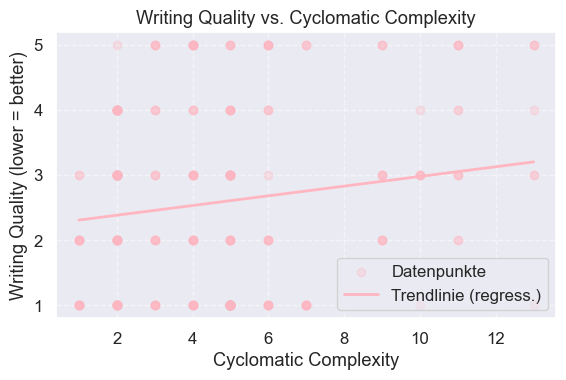

"# ⬇️ NEU: Werte umkehren für bessere Darstellung (1 = Beste → 5 = Schlechteste)\nfor col in ['Instruction Following', 'Correctness', 'Writing Quality']:\n    df_results[col + '_Quality'] = 6 - df_results[col]\n\n# Balkendiagramm nach Prompt\ngrouped_prompt = df_results.groupby('Prompt').agg({\n    'Instruction Following_Quality': 'mean',\n    'Correctness_Quality': 'mean',\n    'Writing Quality_Quality': 'mean'\n}).reset_index()\n\nprompts = grouped_prompt['Prompt'].astype(str)\nx = np.arange(len(prompts))\nwidth = 0.25\n\nplt.figure(figsize=(8,5))\nplt.bar(x - width, grouped_prompt['Instruction Following_Quality'], width, label='Instruction Following')\nplt.bar(x        , grouped_prompt['Correctness_Quality'], width, label='Correctness')\nplt.bar(x + width, grouped_prompt['Writing Quality_Quality'], width, label='Writing Quality')\n\nplt.xlabel('Prompt')\nplt.ylabel('Average Quality (higher = better)')\nplt.title('Average Quality by Prompt')\nplt.xticks(x, prompts)\nplt.legend()\nplt

In [ ]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

custom_palette = ["#ffb6c1", "#90ee90", "#add8e6"]
sns.set(style="darkgrid", palette=custom_palette, font_scale=1.1)

# Daten laden
df_results = pd.read_csv('LLM-Generated M2T Results Analysis - CLEANED.csv')
df_graph   = pd.read_csv('graph_stats.csv')

# Golden Descriptions ignorieren
df_results = df_results[df_results['Text Type'] != 'Golden Description']

# Datei-Name extrahieren und mergen
df_results['File'] = df_results['Process Model'].apply(lambda x: os.path.splitext(os.path.basename(x))[0])
df_merged = pd.merge(df_results, df_graph, on='File')
df_scatter = df_merged[df_merged['Writing Quality'].notna()]

# Punktdiagramm: Cyclomatic Complexity vs. Correctness
x = df_scatter['Cyclomatic Complexity'].values
y = df_scatter['Writing Quality'].values

coeffs = np.polyfit(x, y, 1)
poly   = np.poly1d(coeffs)

x_line = np.linspace(x.min(), x.max(), 200)
y_line = poly(x_line)

plt.figure(figsize=(6,4))
plt.scatter(x, y, alpha=0.3, label='Datenpunkte')
plt.plot(x_line, y_line, '-', linewidth=2, label='Trendlinie (regress.)')
plt.xlabel('Cyclomatic Complexity')
plt.ylabel('Writing Quality (lower = better)')
plt.title('Writing Quality vs. Cyclomatic Complexity')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# ⬇️ NEU: Werte umkehren für bessere Darstellung (1 = Beste → 5 = Schlechteste)
for col in ['Instruction Following', 'Correctness', 'Writing Quality']:
    df_results[col + '_Quality'] = 6 - df_results[col]

# Balkendiagramm nach Prompt
grouped_prompt = df_results.groupby('Prompt').agg({
    'Instruction Following_Quality': 'mean',
    'Correctness_Quality': 'mean',
    'Writing Quality_Quality': 'mean'
}).reset_index()

prompts = grouped_prompt['Prompt'].astype(str)
x = np.arange(len(prompts))
width = 0.25

plt.figure(figsize=(8,5))
plt.bar(x - width, grouped_prompt['Instruction Following_Quality'], width, label='Instruction Following')
plt.bar(x        , grouped_prompt['Correctness_Quality'], width, label='Correctness')
plt.bar(x + width, grouped_prompt['Writing Quality_Quality'], width, label='Writing Quality')

plt.xlabel('Prompt')
plt.ylabel('Average Quality (higher = better)')
plt.title('Average Quality by Prompt')
plt.xticks(x, prompts)
plt.legend()
plt.tight_layout()
plt.show()

# Balkendiagramm nach LLM Model
grouped_model = df_results.groupby('LLM Model').agg({
    'Instruction Following_Quality': 'mean',
    'Correctness_Quality': 'mean',
    'Writing Quality_Quality': 'mean'
}).reset_index()

models = grouped_model['LLM Model'].astype(str)
x = np.arange(len(models))

plt.figure(figsize=(8,5))
plt.bar(x - width, grouped_model['Instruction Following_Quality'], width, label='Instruction Following')
plt.bar(x        , grouped_model['Correctness_Quality'], width, label='Correctness')
plt.bar(x + width, grouped_model['Writing Quality_Quality'], width, label='Writing Quality')

plt.xlabel('LLM Model')
plt.ylabel('Average Quality (higher = better)')
plt.title('Average Quality by LLM')
plt.xticks(x, models)
plt.legend()
plt.tight_layout()
plt.show()